In [1]:
import os
import sys
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from scipy import stats

In [4]:
sys.path.append('../utils/')

In [5]:
from dlc_helper import DLC_tracking
from features import *
from features_speed import *
from preprocess_dlc import *

In [6]:
from joblib import Parallel, delayed

# DLC Data

In [8]:
with open(r'../../data/path_to_videos_with_dlc_results_to_calc_speed.txt', 'r') as file:
    list_DLC_filepaths = [line.rstrip() for line in file]
len(list_DLC_filepaths)

500

In [9]:
def get_features(filepath):

    # Read the DLC results file as a pandas DataFrame object
    filename = os.path.basename(filepath)
    foldername = os.path.dirname(filepath)
    dlc_obj = DLC_tracking(filename, foldername)
    df_data = dlc_obj.df_data

    # Interpolate missing datapoints (dorsal)
    df_dorsal = df_data.filter(regex='^(NT_|TT_|D).*(x|y)$')
    df_dorsal_filt = df_dorsal[df_dorsal.isna().sum(axis=1) < 5]
    df_dorsal_x = df_dorsal_filt.filter(like='_x')
    df_dorsal_y = df_dorsal_filt.filter(like='_y')
    df_dorsal_interp_x = interpol_spatial(df_dorsal_x)
    df_dorsal_interp_y = interpol_spatial(df_dorsal_y)
    df_dorsal_x_fin = interpol_temporal(df_dorsal_interp_x)
    df_dorsal_y_fin = interpol_temporal(df_dorsal_interp_y)
    df_dorsal_fin = df_dorsal_x_fin.join(df_dorsal_y_fin)[df_dorsal.columns]
    dorsal_xy_vals = df_dorsal_fin.values.reshape((-1,15,2))
    
    # Calculate length
    skel_lengths = get_length(dorsal_xy_vals)
    skel_lengths_ppsum = get_length(dorsal_xy_vals, len_type='sum_point_to_point')
    skel_lengths_ppavg = get_length(dorsal_xy_vals, len_type='mean_point_to_point')
    df_skel_lengths = pd.DataFrame(index= df_dorsal_fin.index, columns=['len_NT_to_TT', 'len_sum_of_parts', 'len_mean_of_parts'])
    df_skel_lengths['len_NT_to_TT'] = list(skel_lengths)
    df_skel_lengths['len_sum_of_parts'] = list(skel_lengths_ppsum)
    df_skel_lengths['len_mean_of_parts'] = list(skel_lengths_ppavg)

    # Calculate curvatures
    curv_vals = get_curv_savgol(dorsal_xy_vals, wl=9)
    df_curv = pd.DataFrame(curv_vals, index= df_dorsal_fin.index, columns=[f'curv_{x.split("_")[0]}' for x in df_dorsal_x.columns])

    # Calculate quirkiness
    quirkiness = get_quirkiness(dorsal_xy_vals)
    df_quirk = pd.DataFrame(quirkiness,  index= df_dorsal_fin.index, columns=['quirkiness'])

    # Calculate speeds
    # df_dorsal_speeds = get_speeds(df_dorsal_fin)
    df_dorsal_speeds = get_speeds(df_dorsal_fin.reindex(df_data.index), filt=True)
    df_dorsal_speeds = df_dorsal_speeds.reindex(df_dorsal_fin.index)
    
    # Interpolate missing datapoints (ventral) if less than 2 ventral points are missing!
    df_ventral = df_data.filter(regex='^V.*(x|y)$')
    df_ventral_filt = df_ventral[df_ventral.isna().sum(axis=1) < 5]
    df_ventral_x = df_ventral_filt.filter(like='_x')
    df_ventral_y = df_ventral_filt.filter(like='_y')
    df_ventral_interp_x = interpol_spatial(df_ventral_x)
    df_ventral_interp_y = interpol_spatial(df_ventral_y)
    df_ventral_x_fin = interpol_temporal(df_ventral_interp_x)
    df_ventral_y_fin = interpol_temporal(df_ventral_interp_y)
    df_ventral_fin = df_ventral_x_fin.join(df_ventral_y_fin)[df_ventral.columns]

    # Calculate speed : ventral
    df_ventral_speeds = get_speeds(df_ventral_fin.reindex(df_data.index), filt=True)
    df_ventral_speeds = df_ventral_speeds.reindex(df_ventral_fin.index)

    # Is mouth visible
    df_mouth = df_data[['MOUTH_x', 'MOUTH_y']].notna().mean(axis=1)
    df_mouth.name = 'MOUTH'
    
    # Combine all features
    df_feats = df_skel_lengths.join([df_curv, df_quirk, df_dorsal_speeds, df_ventral_speeds])
    df_feats_fin = df_feats.join(df_mouth, how='outer')
    # Test 
    print(df_data.index.min(), df_data.index.max(), len(df_data.index))
    print(df_dorsal_fin.index.min(), df_dorsal_fin.index.max(), len(df_dorsal_fin.index))
    print(df_skel_lengths.index.min(), df_skel_lengths.index.max(), len(df_skel_lengths.index))
    print(df_curv.index.min(), df_curv.index.max(), len(df_curv.index))
    print(df_quirk.index.min(), df_quirk.index.max(), len(df_quirk.index))
    print(df_dorsal_speeds.index.min(), df_dorsal_speeds.index.max(), len(df_dorsal_speeds.index))
    print(df_ventral_speeds.index.min(), df_ventral_speeds.index.max(), len(df_ventral_speeds.index))
    print(df_mouth.index.min(), df_mouth.index.max(), len(df_mouth.index))
    print(df_feats.index.min(), df_feats.index.max(), len(df_feats.index))

    return df_feats_fin
    

In [10]:
filename = os.path.basename(list_DLC_filepaths[0])
foldername = os.path.dirname(list_DLC_filepaths[0])
dlc_obj = DLC_tracking(filename, foldername)
df_data = dlc_obj.df_data
df_data

,frame,NT_x,NT_y,NT_likelihood,EYE_x,EYE_y,EYE_likelihood,DH1_x,DH1_y,DH1_likelihood,...,VNP_x,VNP_y,VNP_likelihood,MOUTH_x,MOUTH_y,MOUTH_likelihood,NTB_x,NTB_y,NTB_likelihood,n_missing_bodyparts
0,0,938.709,947.858,1.0,932.352,950.601,1.000,929.490,952.763,1.000,...,921.783,962.363,1.000,NaN,NaN,0.000,934.396,954.232,1.000,1
1,1,1044.959,884.471,1.0,1040.227,886.421,1.000,1035.960,887.879,1.000,...,NaN,NaN,0.000,NaN,NaN,0.000,NaN,NaN,0.000,13
2,2,1049.591,883.028,1.0,1041.855,884.872,0.997,1036.525,889.866,0.819,...,NaN,NaN,0.000,NaN,NaN,0.000,NaN,NaN,0.000,13
3,3,1045.842,883.475,1.0,1041.295,884.769,1.000,1035.775,886.278,1.000,...,NaN,NaN,0.000,NaN,NaN,0.000,NaN,NaN,0.000,13
4,4,1045.890,883.220,1.0,1041.345,884.592,1.000,1036.169,885.256,1.000,...,NaN,NaN,0.000,NaN,NaN,0.000,NaN,NaN,0.000,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26979,26979,492.915,933.890,1.0,485.851,929.593,1.000,483.594,926.838,1.000,...,476.487,917.913,0.999,478.956,924.577,0.373,484.922,929.262,0.996,0
26980,26980,494.674,934.454,1.0,490.396,931.008,1.000,484.374,928.463,1.000,...,476.052,921.923,1.000,484.874,924.627,0.840,491.193,930.407,1.000,0
26981,26981,495.626,935.882,1.0,490.513,932.308,1.000,485.800,928.844,1.000,...,476.427,922.254,1.000,485.451,924.679,0.758,491.524,930.549,1.000,0
26982,26982,496.118,935.861,1.0,491.233,933.039,1.000,486.615,929.731,1.000,...,476.531,922.400,1.000,485.646,924.512,0.660,492.209,931.309,1.000,0


In [11]:
# Testing 
df_feats_test = get_features(list_DLC_filepaths[0])

0 26983 26984
0 26983 26635
0 26983 26635
0 26983 26635
0 26983 26635
0 26983 26635
0 26983 15328
0 26983 26984
0 26983 26635


In [ ]:
df_feats_test.columns

In [ ]:
df_feats_test

In [12]:
list_df_feats = Parallel(n_jobs=40)(delayed(get_features)(fpath, ) for fpath in list_DLC_filepaths)

0 8899 8900
0 8899 8899
0 8899 8899
0 8899 8899
0 8899 8899
0 8899 8899
0 8899 8175
0 8899 8900
0 8899 8899
0 8999 9000
0 8999 9000
0 8999 9000
0 8999 9000
0 8999 9000
0 8999 9000
0 8999 9000
0 8999 9000
0 8999 9000
0 8965 8966
0 8965 8028
0 8965 8028
0 8965 8028
0 8965 8028
0 8965 8028
0 8965 5494
0 8965 8966
0 8965 8028
0 8941 8942
0 8941 8937
0 8941 8937
0 8941 8937
0 8941 8937
0 8941 8937
0 8914 6949
0 8941 8942
0 8941 8937
0 8725 8726
0 8725 8726
0 8725 8726
0 8725 8726
0 8725 8726
0 8725 8726
4 8719 3344
0 8725 8726
0 8725 8726
0 8788 8789
0 8788 8789
0 8788 8789
0 8788 8789
0 8788 8789
0 8788 8789
0 8788 8782
0 8788 8789
0 8788 8789
0 9000 9001
0 9000 8891
0 9000 8891
0 9000 8891
0 9000 8891
0 9000 8891
3 8999 5246
0 9000 9001
0 9000 8891
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 8814 8815
0 8814 8620
0 8814 8620
0 8814 8620
0 8814 8620
0 8814 8620
0 8712 6842
0 8814 8815
0 8814 8620
0 9000 9001
0 9000 8984
0 90

../utils/features.py:34: RuntimeWarning: invalid value encountered in true_divide
  quirkiness = np.sqrt(1 - W**2 / L**2)


0 26784 26785
0 26784 26785
0 26784 26785
0 26784 26785
0 26784 26785
0 26784 26785
0 26784 24084
0 26784 26785
0 26784 26785
0 26327 26328
0 26327 26315
0 26327 26315
0 26327 26315
0 26327 26315
0 26327 26315
0 26327 22170
0 26327 26328
0 26327 26315
0 26969 26970
0 26969 25098
0 26969 25098
0 26969 25098
0 26969 25098
0 26969 25098
0 26969 21139
0 26969 26970
0 26969 25098
0 27000 27001
0 27000 21024
0 27000 21024
0 27000 21024
0 27000 21024
0 27000 21024
0 26997 16098
0 27000 27001
0 27000 21024
0 26924 26925
0 26924 22978
0 26924 22978
0 26924 22978
0 26924 22978
0 26924 22978
0 26924 18967
0 26924 26925
0 26924 22978
0 8993 8994
0 8993 8986
0 8993 8986
0 8993 8986
0 8993 8986
0 8993 8986
4 8993 5370
0 8993 8994
0 8993 8986
0 8980 8981
0 8980 8946
0 8980 8946
0 8980 8946
0 8980 8946
0 8980 8946
0 8980 8750
0 8980 8981
0 8980 8946
0 26266 26267
0 26266 26033
0 26266 26033
0 26266 26033
0 26266 26033
0 26266 26033
6 26264 19636
0 26266 26267
0 26266 26033
0 26991 26992
0 26991 26991


0 8919 8920
0 8919 8726
0 8919 8726
0 8919 8726
0 8919 8726
0 8919 8726
0 8919 8280
0 8919 8920
0 8919 8726
0 8830 8831
0 8830 7882
0 8830 7882
0 8830 7882
0 8830 7882
0 8830 7882
0 8830 6600
0 8830 8831
0 8830 7882
0 8934 8935
0 8934 8935
0 8934 8935
0 8934 8935
0 8934 8935
0 8934 8935
0 8934 7629
0 8934 8935
0 8934 8935
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
1 9000 8077
0 9000 9001
0 9000 9001
0 26246 26247
0 26246 26247
0 26246 26247
0 26246 26247
0 26246 26247
0 26246 26247
22 26246 23118
0 26246 26247
0 26246 26247
0 26955 26956
0 26955 26589
0 26955 26589
0 26955 26589
0 26955 26589
0 26955 26589
0 26955 13281
0 26955 26956
0 26955 26589
0 26959 26960
0 26959 26350
0 26959 26350
0 26959 26350
0 26959 26350
0 26959 26350
0 26959 24935
0 26959 26960
0 26959 26350
0 26970 26971
0 26970 26950
0 26970 26950
0 26970 26950
0 26970 26950
0 26970 26950
0 22580 20075
0 26970 26971
0 26970 26950
0 8714 8715
0 8714 8523
0 8714 8523
0 8714 8523
0 8714 8523
0 8

0 8997 8998
0 8997 8998
0 8997 8998
0 8997 8998
0 8997 8998
0 8997 8998
0 8997 8989
0 8997 8998
0 8997 8998
0 26950 26951
0 26950 26917
0 26950 26917
0 26950 26917
0 26950 26917
0 26950 26917
0 26950 25293
0 26950 26951
0 26950 26917
0 8976 8977
0 8976 8958
0 8976 8958
0 8976 8958
0 8976 8958
0 8976 8958
0 8976 8942
0 8976 8977
0 8976 8958
0 8754 8755
0 8754 8574
0 8754 8574
0 8754 8574
0 8754 8574
0 8754 8574
0 8754 8443
0 8754 8755
0 8754 8574
0 26601 26602
0 26601 26177
0 26601 26177
0 26601 26177
0 26601 26177
0 26601 26177
2 26601 25162
0 26601 26602
0 26601 26177
0 8872 8873
0 8872 8720
0 8872 8720
0 8872 8720
0 8872 8720
0 8872 8720
0 8872 8720
0 8872 8873
0 8872 8720
0 8976 8977
0 8976 8977
0 8976 8977
0 8976 8977
0 8976 8977
0 8976 8977
0 8976 8848
0 8976 8977
0 8976 8977
0 8929 8930
0 8929 8930
0 8929 8930
0 8929 8930
0 8929 8930
0 8929 8930
0 8929 8910
0 8929 8930
0 8929 8930
0 26592 26593
0 26592 25869
0 26592 25869
0 26592 25869
0 26592 25869
0 26592 25869
0 26592 17839
0 

../utils/features.py:34: RuntimeWarning: invalid value encountered in true_divide
  quirkiness = np.sqrt(1 - W**2 / L**2)


0 8921 8922
0 8921 8922
0 8921 8922
0 8921 8922
0 8921 8922
0 8921 8922
0 8921 8519
0 8921 8922
0 8921 8922
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 26963 26964
0 26963 24427
0 26963 24427
0 26963 24427
0 26963 24427
0 26963 24427
0 26961 16959
0 26963 26964
0 26963 24427
0 8982 8983
0 8982 8983
0 8982 8983
0 8982 8983
0 8982 8983
0 8982 8983
0 8982 8983
0 8982 8983
0 8982 8983
0 8907 8908
0 8907 7660
0 8907 7660
0 8907 7660
0 8907 7660
0 8907 7660
0 8907 5758
0 8907 8908
0 8907 7660
0 8983 8984
0 8983 8984
0 8983 8984
0 8983 8984
0 8983 8984
0 8983 8984
0 8983 8984
0 8983 8984
0 8983 8984
0 26963 26964
0 26963 26964
0 26963 26964
0 26963 26964
0 26963 26964
0 26963 26964
0 26963 26962
0 26963 26964
0 26963 26964
0 8920 8921
0 8920 8921
0 8920 8921
0 8920 8921
0 8920 8921
0 8920 8921
0 8920 8921
0 8920 8921
0 8920 8921
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
5177 9000 1033
0 9000 9001
0

../utils/features.py:34: RuntimeWarning: invalid value encountered in true_divide
  quirkiness = np.sqrt(1 - W**2 / L**2)


0 26983 26984
0 26983 26635
0 26983 26635
0 26983 26635
0 26983 26635
0 26983 26635
0 26983 15328
0 26983 26984
0 26983 26635
0 8887 8888
0 8886 8306
0 8886 8306
0 8886 8306
0 8886 8306
0 8886 8306
0 8886 8492
0 8887 8888
0 8886 8306
0 8977 8978
0 8977 8978
0 8977 8978
0 8977 8978
0 8977 8978
0 8977 8978
0 8977 8978
0 8977 8978
0 8977 8978
0 26386 26387
0 26386 26361
0 26386 26361
0 26386 26361
0 26386 26361
0 26386 26361
0 26386 24822
0 26386 26387
0 26386 26361
0 8819 8820
0 8819 8237
0 8819 8237
0 8819 8237
0 8819 8237
0 8819 8237
0 8819 8097
0 8819 8820
0 8819 8237
0 26958 26959
0 26958 26066
0 26958 26066
0 26958 26066
0 26958 26066
0 26958 26066
0 26958 23893
0 26958 26959
0 26958 26066
0 9000 9001
1 9000 8425
1 9000 8425
1 9000 8425
1 9000 8425
1 9000 8425
1 9000 6935
0 9000 9001
1 9000 8425
0 26792 26793
0 26792 26792
0 26792 26792
0 26792 26792
0 26792 26792
0 26792 26792
1 26775 12965
0 26792 26793
0 26792 26792
0 8742 8743
1 8742 8681
1 8742 8681
1 8742 8681
1 8742 8681
1 87

../utils/features.py:34: RuntimeWarning: invalid value encountered in true_divide
  quirkiness = np.sqrt(1 - W**2 / L**2)


0 26929 26930
0 26929 21067
0 26929 21067
0 26929 21067
0 26929 21067
0 26929 21067
0 26929 14535
0 26929 26930
0 26929 21067
0 8965 8966
0 8965 8965
0 8965 8965
0 8965 8965
0 8965 8965
0 8965 8965
0 8965 7523
0 8965 8966
0 8965 8965
0 9000 9001
0 9000 8993
0 9000 8993
0 9000 8993
0 9000 8993
0 9000 8993
0 9000 8861
0 9000 9001
0 9000 8993
0 8704 8705
0 8704 8705
0 8704 8705
0 8704 8705
0 8704 8705
0 8704 8705
0 8704 8705
0 8704 8705
0 8704 8705
0 8712 8713
0 8712 8713
0 8712 8713
0 8712 8713
0 8712 8713
0 8712 8713
0 8712 8283
0 8712 8713
0 8712 8713
0 8784 8785
0 8784 8780
0 8784 8780
0 8784 8780
0 8784 8780
0 8784 8780
1 8784 8701
0 8784 8785
0 8784 8780
0 27000 27001
0 26860 13934
0 26860 13934
0 26860 13934
0 26860 13934
0 26860 13934
0 27000 13702
0 27000 27001
0 26860 13934
0 9000 9001
0 8759 8236
0 8759 8236
0 8759 8236
0 8759 8236
0 8759 8236
0 8652 6199
0 9000 9001
0 8759 8236
0 9000 9001
18 9000 6892
18 9000 6892
18 9000 6892
18 9000 6892
18 9000 6892
48 9000 5613
0 9000 900

0 8980 8981
0 8980 8981
0 8980 8981
0 8980 8981
0 8980 8981
0 8980 8981
0 8980 8754
0 8980 8981
0 8980 8981
0 8818 8819
0 8818 8811
0 8818 8811
0 8818 8811
0 8818 8811
0 8818 8811
0 8818 8779
0 8818 8819
0 8818 8811
0 9000 9001
0 9000 8989
0 9000 8989
0 9000 8989
0 9000 8989
0 9000 8989
1 9000 7729
0 9000 9001
0 9000 8989
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 26884 26885
0 14933 14288
0 14933 14288
0 14933 14288
0 14933 14288
0 14933 14288
0 15600 10911
0 26884 26885
0 14933 14288
0 26658 26659
0 26658 25771
0 26658 25771
0 26658 25771
0 26658 25771
0 26658 25771
0 26658 13237
0 26658 26659
0 26658 25771
0 8915 8916
0 8724 7672
0 8724 7672
0 8724 7672
0 8724 7672
0 8724 7672
0 8295 4204
0 8915 8916
0 8724 7672
0 26961 26962
0 26961 26962
0 26961 26962
0 26961 26962
0 26961 26962
0 26961 26962
0 26961 26169
0 

0 8863 8864
0 8863 8864
0 8863 8864
0 8863 8864
0 8863 8864
0 8863 8864
1 8863 6801
0 8863 8864
0 8863 8864
0 26713 26714
0 26713 26677
0 26713 26677
0 26713 26677
0 26713 26677
0 26713 26677
0 26713 25274
0 26713 26714
0 26713 26677
0 27000 27001
0 27000 27001
0 27000 27001
0 27000 27001
0 27000 27001
0 27000 27001
0 27000 27001
0 27000 27001
0 27000 27001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
3 9000 8910
0 9000 9001
0 9000 9001
0 8838 8839
0 8745 6375
0 8745 6375
0 8745 6375
0 8745 6375
0 8745 6375
1 8745 4925
0 8838 8839
0 8745 6375
0 26798 26799
0 26798 24521
0 26798 24521
0 26798 24521
0 26798 24521
0 26798 24521
0 26798 20391
0 26798 26799
0 26798 24521
0 8804 8805
0 8804 8805
0 8804 8805
0 8804 8805
0 8804 8805
0 8804 8805
1 8591 7088
0 8804 8805
0 8804 8805
0 26967 26968
0 26967 21615
0 26967 21615
0 26967 21615
0 26967 21615
0 26967 21615
2 26967 16964
0 26967 26968
0 26967 21615
0 8715 8716
0 8715 8716
0 8715 8716
0 8715 8716
0 8715 8716
0 87

../utils/features.py:34: RuntimeWarning: invalid value encountered in true_divide
  quirkiness = np.sqrt(1 - W**2 / L**2)


0 9000 9001
0 9000 7606
0 9000 7606
0 9000 7606
0 9000 7606
0 9000 7606
4 9000 2707
0 9000 9001
0 9000 7606
0 8823 8824
0 8823 8822
0 8823 8822
0 8823 8822
0 8823 8822
0 8823 8822
0 8823 8055
0 8823 8824
0 8823 8822
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 9001
0 9000 8880
0 9000 9001
0 9000 9001
0 26963 26964
0 26963 26930
0 26963 26930
0 26963 26930
0 26963 26930
0 26963 26930
0 26963 26907
0 26963 26964
0 26963 26930
0 26968 26969
0 26967 24905
0 26967 24905
0 26967 24905
0 26967 24905
0 26967 24905
0 26963 19166
0 26968 26969
0 26967 24905
0 25726 25727
0 25726 24046
0 25726 24046
0 25726 24046
0 25726 24046
0 25726 24046
1 25695 19845
0 25726 25727
0 25726 24046
0 8992 8993
0 8992 8993
0 8992 8993
0 8992 8993
0 8992 8993
0 8992 8993
1 8992 7654
0 8992 8993
0 8992 8993
0 8975 8976
12 8975 4061
12 8975 4061
12 8975 4061
12 8975 4061
12 8975 4061
12 8964 3066
0 8975 8976
12 8975 4061
0 9000 9001
0 9000 8807
0 9000 8807
0 9000 8807
0 9000 8807
0 9000 8807
0 9

# Outliers and other stats

In [85]:
def remove_outliers(df, col, thresh=[0,200]):
    # global outlier_free_list 
    global df_wo_outliers

    if col.startswith('curv'):
        Q1, Q3 = df[col].quantile([.25, .75])
        IQR = Q3 - Q1
        
        thresh[0] = Q1 - 5 * IQR
        thresh[1] = Q3 + 5 * IQR
        df_wo_outliers = df[(df[col] > thresh[0]) & (df[col] < thresh[1])]
        
    elif col.startswith('len'):
        df_wo_outliers = df[(df[col] > thresh[0]) & (df[col] < thresh[1])]
        
    elif col.startswith('speed_V'):
        df_wo_outliers = df[df[col].isna()| ((df[col] > 0) & (df[col] < thresh[1]))]
        
    elif col.startswith('speed'):
        df_wo_outliers = df[((df[col] > 0) & (df[col] < thresh[1]))]
        

In [86]:
df_combined_test = pd.concat(list_df_feats)
df_combined_test.shape

(6950693, 46)

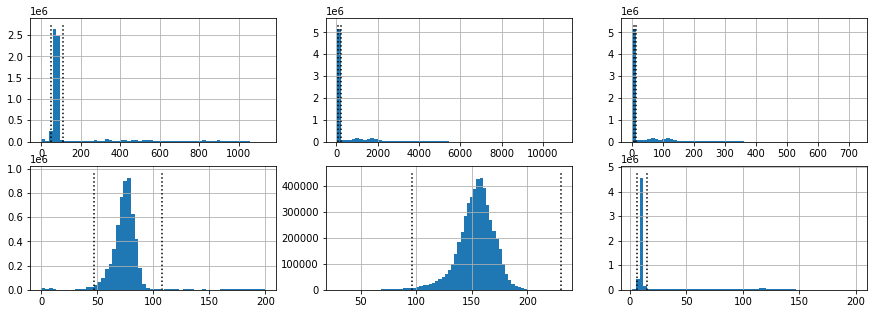

In [87]:
fig, axes = plt.subplots(2,3,figsize=(15,5))

for i, col in enumerate(['len_NT_to_TT','len_sum_of_parts', 'len_mean_of_parts']):
    hist = df_combined_test[col].hist(bins=60, ax=axes[0][i])
    hist1 = df_combined_test.loc[df_combined_test[col]<200,col].hist(bins=60, ax=axes[1][i])
    
    Q1, Q3 = df_combined_test[col].quantile([.25, .75])
    IQR = Q3 - Q1
    low_thresh = Q1 - 1.7*IQR
    high_thresh = Q3 + 1.7*IQR
    ymin, ymax = hist.get_ylim()
    axes[0][i].vlines(x=[low_thresh, high_thresh], ymax= ymax, ymin=ymin, colors='k', linestyles='dotted')
    ymin1, ymax1 = hist1.get_ylim()
    axes[1][i].vlines(x=[low_thresh, high_thresh], ymax= ymax1, ymin=ymin1, colors='k', linestyles='dotted')

In [88]:
remove_outliers(df_combined_test, 'len_NT_to_TT',[25,120])
remove_outliers(df_wo_outliers, 'len_sum_of_parts',[75,200])

In [89]:
len(df_wo_outliers.index) / len(df_combined_test.index)

0.7311882426687526

In [90]:
cols_curv = list(df_wo_outliers.filter(like='curv').columns)
cols_curv

['curv_NT',
 'curv_DH1',
 'curv_DH2',
 'curv_DNP',
 'curv_DTP1',
 'curv_DTP2',
 'curv_DTP3',
 'curv_DTP4',
 'curv_DTP5',
 'curv_DTP6',
 'curv_DTP7',
 'curv_DTP8',
 'curv_DTP9',
 'curv_DTP10',
 'curv_TT']

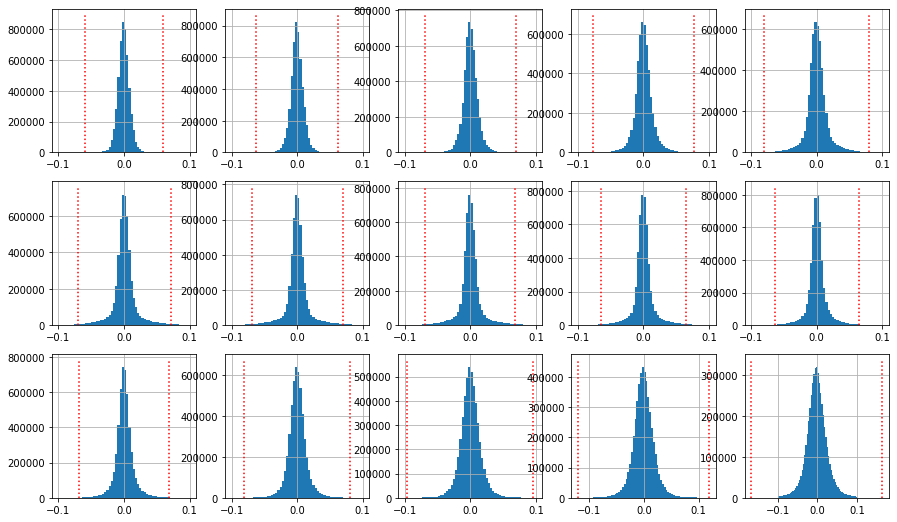

In [91]:
fig, axes = plt.subplots(3,5,figsize=(15, 9))
axes = axes.ravel()
for i, col in enumerate(cols_curv):
    hist = df_wo_outliers.loc[(df_wo_outliers[col]<0.1) & (df_wo_outliers[col]>-0.1), col].hist(ax=axes[i], bins=60)
    # .loc[(df_wo_outliers[col]<0.1) & (df_wo_outliers[col]>-0.1), col]
    
    # print(stats.shapiro(df_combined_test.loc[(df_combined_test[col]<0.1) & (df_combined_test[col]>-0.1), col]))
    Q1, Q3 = df_wo_outliers[col].quantile([.25, .75])
    IQR = Q3 - Q1
    low_thresh = Q1 - 5*IQR
    high_thresh = Q3 + 5*IQR
    
    ymin, ymax = hist.get_ylim()
    axes[i].vlines(x=[low_thresh, high_thresh], ymax= ymax, ymin=ymin, colors='r', linestyles='dotted')

In [92]:
for i, col in enumerate(cols_curv):
    remove_outliers(df_wo_outliers, col)

In [93]:
len(df_wo_outliers.index) / len(df_combined_test.index)

0.6992334433415488

In [94]:
cols_speed = list(df_combined_test.filter(like='speed').columns)
len(cols_speed)

26

In [ ]:
sample_curves = np.random.choice(df_combined_test.loc[df_combined_test[cols_speed].isna().sum(axis=1) == 0, cols_speed].values.ravel(), 1000, replace=False)
stats.lognorm.fit(sample_curves)

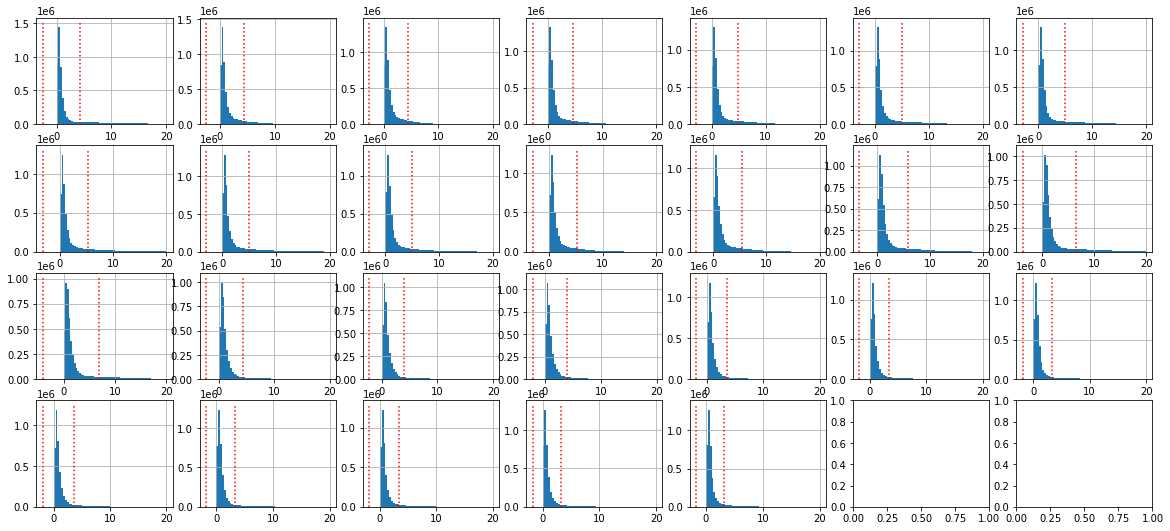

In [95]:
fig, axes = plt.subplots(4,7,figsize=(20, 9))
axes = axes.ravel()
for i, col in enumerate(cols_speed):
    hist = df_wo_outliers.loc[(df_wo_outliers[col] >= 0) & (df_wo_outliers[col] < 20), col].hist(ax=axes[i], bins=60)
    
    # print(stats.kstest(df_combined_test.loc[(df_combined_test[col]<20), col], "lognorm", stats.lognorm.fit(sample_curves)))
    Q1, Q3 = df_wo_outliers[col].quantile([.25, .75])
    IQR = Q3 - Q1
    low_thresh = Q1 - 3*IQR
    high_thresh = Q3 + 3*IQR
    
    ymin, ymax = hist.get_ylim()
    axes[i].vlines(x=[low_thresh, high_thresh], ymax= ymax, ymin=ymin, colors='r', linestyles='dotted')

/share/python-virtual-environments/vame0_1/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/share/python-virtual-environments/vame0_1/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.007536815656254073 76.98855818268952
0.009002564300726686 69.2028708445663
0.008735631044377702 76.71878760113286
0.008071858482581917 87.50956629943096
0.007324879738553132 103.87095960670322
0.007087423728201142 104.81199024794398
0.006782057459366539 109.92097357173921
0.006158030590783657 135.52497477533845
0.00658321547165717 120.02526101482316
0.006761522350536738 116.68613510160039
0.007683099144863213 108.88375030198873
0.008278525088023958 111.72491675610536
0.007365898951689277 138.39142345721987
0.007873659959553019 155.0504770990919
0.007489556490512498 172.09221679124252
0.016972752669268495 40.72626620374881
0.016058971764639475 38.291109529246185
0.016230626844207813 36.75177029068285
0.016224895558453523 31.075291902393595
0.015451634633758891 30.433883078224284
0.015125616375725435 31.15167776672319
0.014864288250536309 33.691752658009975
0.01493936491599204 29.99514716369627
0.014889795066891755 31.629983462965004
0.015009045156627371 28.66462296661531
0.01474604547

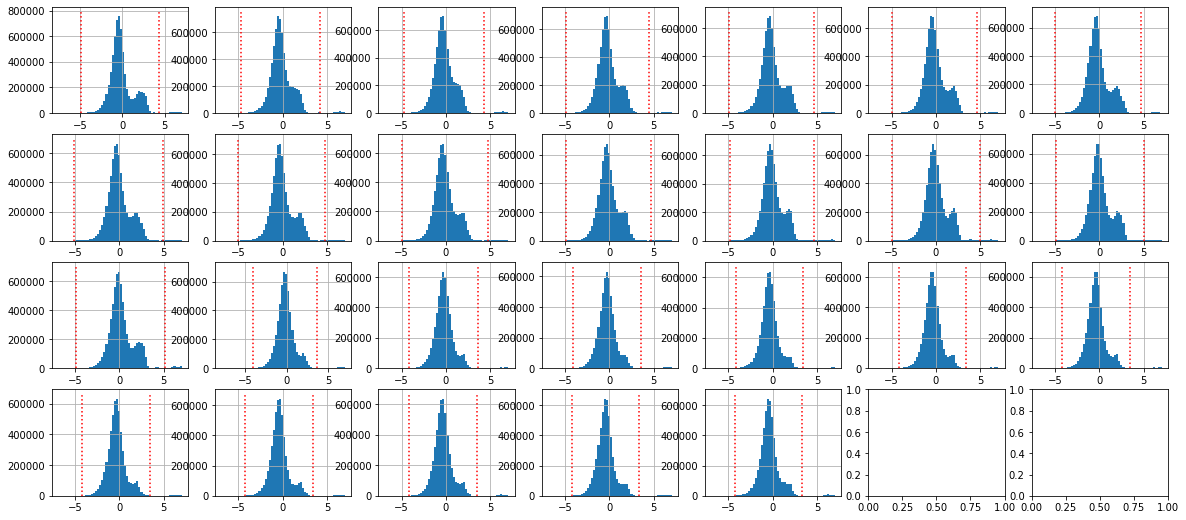

In [96]:
fig, axes = plt.subplots(4,7,figsize=(20, 9))
dict_thresh_speeds = {}
axes = axes.ravel()
df_combined_test.replace([np.inf, -np.inf], np.nan, inplace=True)

for i, col in enumerate(cols_speed):
    sel_data = df_combined_test[col]
    sel_data = sel_data[(sel_data.notna())]
    log_vals = np.log(sel_data)
    hist = log_vals[(log_vals!=np.inf)&(log_vals!=-1*np.inf)&(log_vals!=np.nan)].hist(ax =axes[i], bins=60)
    
    Q1, Q3 = log_vals.quantile([.25, .75])
    IQR = Q3 - Q1
    low_thresh = Q1 - 3*IQR
    high_thresh = Q3 + 3*IQR

    dict_thresh_speeds[col] = [low_thresh, high_thresh]

    print(np.exp(low_thresh), np.exp(high_thresh))
    
    ymin, ymax = hist.get_ylim()
    axes[i].vlines(x=[low_thresh, high_thresh], ymax= ymax, ymin=ymin, colors='r', linestyles='dotted')

In [97]:
for i, col in enumerate(cols_speed[:15]):
    remove_outliers(df_wo_outliers, col, dict_thresh_speeds[col])

In [98]:
for i, col in enumerate(cols_speed[15:]):
    remove_outliers(df_wo_outliers, col, dict_thresh_speeds[col])

In [99]:
(len(df_wo_outliers.index) / len(df_combined_test.index)) * 100

49.025370563769684

<AxesSubplot:>

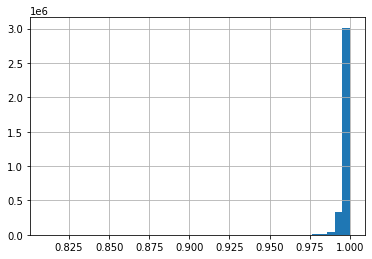

In [100]:
df_wo_outliers['quirkiness'].hist(bins=40)

In [101]:
len(df_wo_outliers.index)

3407603

# Stats

In [102]:
df_wo_outliers['speed_VTP10'].min()

0.0009999999999763531

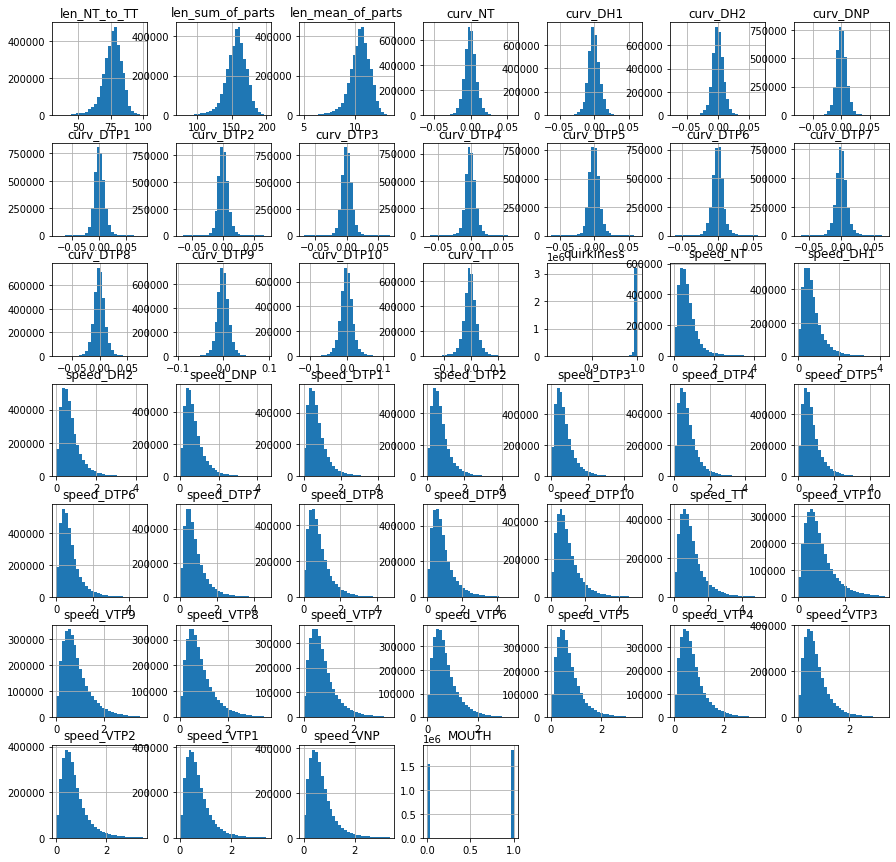

In [103]:
df_wo_outliers.hist(bins=30, figsize=(15,15))
plt.show()

In [106]:
df_wo_outliers.index

3407603

In [108]:
df_wo_outliers.to_hdf('../../results/pickled_featureset.h5', key='features')

In [109]:
df_wo_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3407603 entries, 0 to 8993
Data columns (total 46 columns):
 #   Column             Dtype  
---  ------             -----  
 0   len_NT_to_TT       float64
 1   len_sum_of_parts   float64
 2   len_mean_of_parts  float64
 3   curv_NT            float64
 4   curv_DH1           float64
 5   curv_DH2           float64
 6   curv_DNP           float64
 7   curv_DTP1          float64
 8   curv_DTP2          float64
 9   curv_DTP3          float64
 10  curv_DTP4          float64
 11  curv_DTP5          float64
 12  curv_DTP6          float64
 13  curv_DTP7          float64
 14  curv_DTP8          float64
 15  curv_DTP9          float64
 16  curv_DTP10         float64
 17  curv_TT            float64
 18  quirkiness         float64
 19  speed_NT           float64
 20  speed_DH1          float64
 21  speed_DH2          float64
 22  speed_DNP          float64
 23  speed_DTP1         float64
 24  speed_DTP2         float64
 25  speed_DTP3         fl

In [110]:
df_wo_outliers.isna().sum()

len_NT_to_TT              0
len_sum_of_parts          0
len_mean_of_parts         0
curv_NT                   0
curv_DH1                  0
curv_DH2                  0
curv_DNP                  0
curv_DTP1                 0
curv_DTP2                 0
curv_DTP3                 0
curv_DTP4                 0
curv_DTP5                 0
curv_DTP6                 0
curv_DTP7                 0
curv_DTP8                 0
curv_DTP9                 0
curv_DTP10                0
curv_TT                   0
quirkiness                0
speed_NT                  0
speed_DH1                 0
speed_DH2                 0
speed_DNP                 0
speed_DTP1                0
speed_DTP2                0
speed_DTP3                0
speed_DTP4                0
speed_DTP5                0
speed_DTP6                0
speed_DTP7                0
speed_DTP8                0
speed_DTP9                0
speed_DTP10               0
speed_TT                  0
speed_VTP10          332629
speed_VTP9          

In [112]:
df_wo_outliers.shape

(3407603, 46)